# The Project: Gender Classification from Voice Features

This project focuses on building and evaluating machine learning models for **gender classification** based on voice recordings. The dataset includes acoustic features extracted from male and female voice samples using the Librosa Python library. After preprocessing and balancing, multiple supervised models are trained, tuned, and compared using cross-validation.

## Dataset

- Source: [Kaggle - Male and Female Voice Data](https://www.kaggle.com/datasets/alarmanovi/male-and-female-voice-data-for-gender-recognation)
- Samples: 5,993 voice recordings
  - 3,682 male
  - 2,311 female
- Features: 20+ numerical acoustic features (mean frequency, spectral flatness, fundamental frequency, etc.)
- Label: Gender (`male` or `female`), encoded as binary (`1` and `0`)

## Pipeline Overview

1. **Preprocessing**
   - Label encoding
   - Feature normalization (MinMaxScaler)
   - Oversampling with `RandomOverSampler` to balance classes

2. **Model Training and Tuning**
   - Models used:
     - RandomForestClassifier
     - HistGradientBoostingClassifier
     - MLPClassifier (from sklearn)
     - XGBoostClassifier
   - Hyperparameter tuning via `RandomizedSearchCV`
   - Best parameters selected for each model

3. **Evaluation**
   - 10-fold Stratified Cross-Validation
   - Metrics:
     - Accuracy
     - F1-weighted
   - Visualization of model comparison with error bars (± standard deviation)

## Results

| Model                  | Accuracy | F1-weighted |
|------------------------|----------|-------------|
| HistGradientBoosting   | 87.91%   | 87.90%      |
| RandomForest           | 87.15%   | 87.15%      |
| XGBoost                | 86.95%   | 86.94%      |
| MLPClassifier          | 80.04%   | 80.02%      |

The best performance was achieved by **HistGradientBoostingClassifier**, which combined strong accuracy and stability across folds.

## Conclusion

This project demonstrates that even with a relatively small tabular dataset, high accuracy in gender classification can be achieved using traditional ML algorithms, proper feature preprocessing, and systematic cross-validation.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

=== Running Fast RandomizedSearchCV with Diagnostic Output (auto n_iter) ===

--- Tuning RandomForest ---
Parameter space size: 8. Using n_iter = 8.
Parameter grid: {'n_estimators': [100, 300], 'max_depth': [None, 10], 'min_samples_split': [2, 5], 'class_weight': ['balanced']}
Best parameters for RandomForest: {'n_estimators': 300, 'min_samples_split': 5, 'max_depth': None, 'class_weight': 'balanced'}

--- Tuning HistGradientBoosting ---
Parameter space size: 16. Using n_iter = 10.
Parameter grid: {'learning_rate': [0.05, 0.1], 'max_iter': [100, 300], 'max_depth': [None, 10], 'l2_regularization': [0.0, 0.1]}
Best parameters for HistGradientBoosting: {'max_iter': 300, 'max_depth': None, 'learning_rate': 0.1, 'l2_regularization': 0.0}

--- Tuning MLPClassifier ---
Parameter space size: 8. Using n_iter = 8.
Parameter grid: {'hidden_layer_sizes': [(64,), (128,)], 'activation': ['relu'], 'alpha': [0.0001, 0.001], 'learning_rate_init': [0.001, 0.01]}
Best parameters for MLPClassifier: {'lear

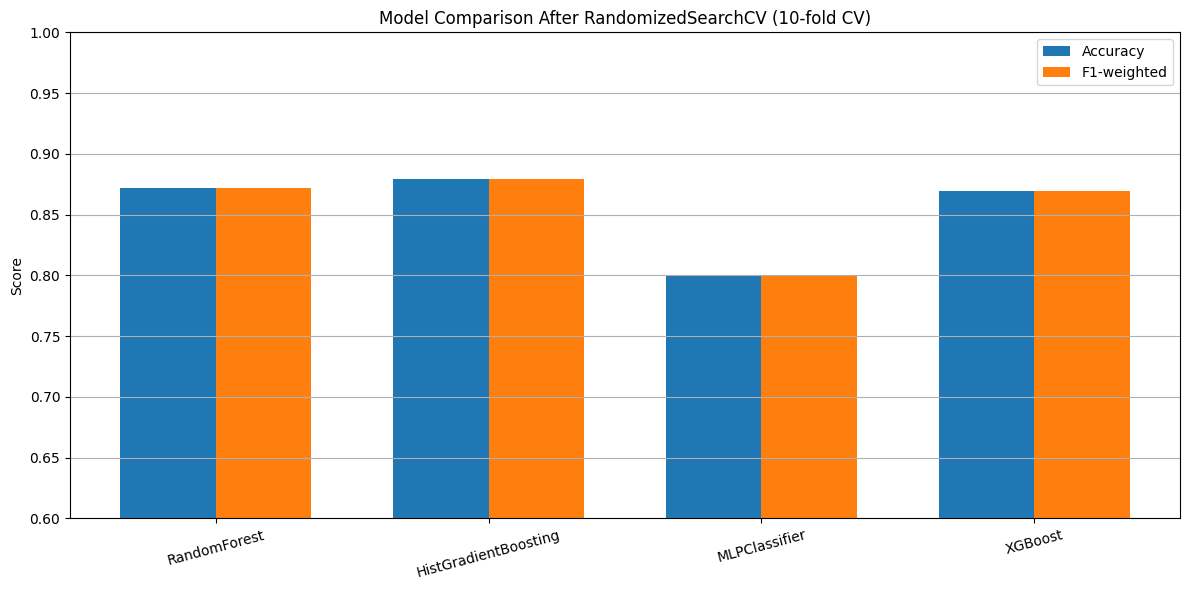

In [3]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler

# === Load dataset ===
df = pd.read_csv("/content/drive/MyDrive/Portfolio datasets/Audio/Male and female Voice data.csv")

# Encode labels
label_col = 'label' if 'label' in df.columns else 'gender'
le = LabelEncoder()
df['target'] = le.fit_transform(df[label_col])

# Separate X and y
X = df.drop([label_col, 'target'], axis=1)
y = df['target']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Balance classes BEFORE split
ros = RandomOverSampler(random_state=42)
X_bal, y_bal = ros.fit_resample(X_scaled, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.30, random_state=42, stratify=y_bal
)

print("=== Running Fast RandomizedSearchCV with Diagnostic Output (auto n_iter) ===")

# Define models
models = {
    "RandomForest": RandomForestClassifier(n_jobs=-1, random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(128, 64), early_stopping=True, max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.05, eval_metric='logloss', random_state=42)
}

# Parameter spaces (reduced and sensible for speed)
param_grids = {
    "RandomForest": {
        'n_estimators': [100, 300],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
        'class_weight': ['balanced']
    },
    "HistGradientBoosting": {
        'learning_rate': [0.05, 0.1],
        'max_iter': [100, 300],
        'max_depth': [None, 10],
        'l2_regularization': [0.0, 0.1]
    },
    "MLPClassifier": {
        'hidden_layer_sizes': [(64,), (128,)],
        'activation': ['relu'],
        'alpha': [1e-4, 1e-3],
        'learning_rate_init': [0.001, 0.01]
    },
    "XGBoost": {
        'n_estimators': [100, 300],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.05],
        'subsample': [0.8, 1.0]
    }
}

# RandomizedSearchCV with auto n_iter <= number of possible combinations (to avoid warnings)
for model_name in ["RandomForest", "HistGradientBoosting", "MLPClassifier", "XGBoost"]:
    print(f"\n--- Tuning {model_name} ---")
    base_model = models[model_name]
    param_grid = param_grids[model_name]

    # Compute total combinations
    total_combinations = int(np.prod([len(v) for v in param_grid.values()]))
    n_iter = min(10, total_combinations)  # auto-adjust to avoid the "smaller than n_iter" warning
    print(f"Parameter space size: {total_combinations}. Using n_iter = {n_iter}.")
    print(f"Parameter grid: {param_grid}")

    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring='f1_weighted',
        cv=3,                 # reduce CV folds for speed
        n_jobs=-1,            # parallelize across cores
        random_state=42
    )

    search.fit(X_train, y_train)
    models[model_name] = search.best_estimator_
    print(f"Best parameters for {model_name}: {search.best_params_}")

# Evaluation using StratifiedKFold (10-fold)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print(f"\nUsing StratifiedKFold: {cv}")

acc_results = {}
f1_results = {}

for name, model in models.items():
    print(f"\nEvaluating {name} on full balanced dataset with cross_val_score...")
    acc = cross_val_score(model, X_bal, y_bal, cv=cv, scoring='accuracy', n_jobs=-1)
    f1 = cross_val_score(model, X_bal, y_bal, cv=cv, scoring='f1_weighted', n_jobs=-1)
    acc_results[name] = acc.mean()
    f1_results[name] = f1.mean()
    print(f"{name}: Accuracy = {acc.mean():.4f}, F1_weighted = {f1.mean():.4f}")

# Plot comparison
plt.figure(figsize=(12, 6))
bar_width = 0.35
x = np.arange(len(models))

plt.bar(x - bar_width/2, list(acc_results.values()), width=bar_width, label='Accuracy')
plt.bar(x + bar_width/2, list(f1_results.values()), width=bar_width, label='F1-weighted')
plt.xticks(x, list(acc_results.keys()), rotation=15)
plt.ylabel("Score")
plt.ylim(0.6, 1.0)
plt.title("Model Comparison After RandomizedSearchCV (10-fold CV)")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Training final model: HistGradientBoosting with tuned parameters

--- Final Evaluation on Test Set ---
Accuracy: 0.8728506787330317

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.88      1105
           1       0.93      0.81      0.86      1105

    accuracy                           0.87      2210
   macro avg       0.88      0.87      0.87      2210
weighted avg       0.88      0.87      0.87      2210



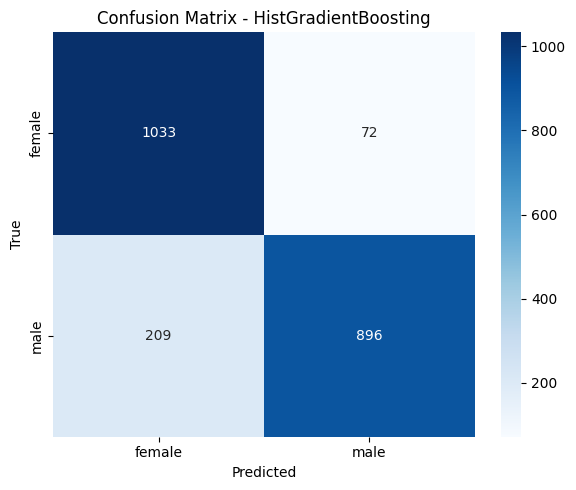


Model saved as 'best_HistGradientBoosting_model.joblib'

Reloaded model test accuracy: 0.8728506787330317


In [4]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import joblib
import matplotlib.pyplot as plt

# Select the best model (HistGradientBoosting)
best_model = models["HistGradientBoosting"]
print("Training final model: HistGradientBoosting with tuned parameters")

# Fit on full training set
best_model.fit(X_train, y_train)

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluation
print("\n--- Final Evaluation on Test Set ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - HistGradientBoosting")
plt.tight_layout()
plt.show()

# Save model
joblib.dump(best_model, "best_HistGradientBoosting_model.joblib")
print("\nModel saved as 'best_HistGradientBoosting_model.joblib'")

# Reload and test again
loaded_model = joblib.load("best_HistGradientBoosting_model.joblib")
y_loaded_pred = loaded_model.predict(X_test)
print("\nReloaded model test accuracy:", accuracy_score(y_test, y_loaded_pred))
